Use K-means clustering to predict future returns on futures contracts for commodities, equitiess and the dollar.

Import Packages

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from pandas.api.types import CategoricalDtype

Download Futures Data from yfinance:
USD, Gold, Silver, Copper, Brent Crude Oil, Natural Gas, Corn, Soybean, S&P 500, Nasdaq 100, Russell 2000

Store only closing data in the df we will use

In [2]:
tickers = ['DX=F', 'GC=F', 'SI=F', 'HG=F', 'BZ=F', 'NG=F', 'ZC=F', 'ZS=F', 'ES=F', 'NQ=F']
ticker_to_name = {
    "BZ=F": "Crude",
    "GC=F": "Gold",
    "NG=F": "Nat_Gas",
    "SI=F": "Silver",
    "ZC=F": "Corn",
    "ZS=F": "Soybeans",
    "ES=F": "S&P_500",
    "NQ=F": "Nasdaq_100",
    "DX=F": "USD",
    "HG=F": "Copper"
}

full_data = yf.download(tickers, start = '2010-01-01', end='2024-12-31')
full_data.columns = full_data.columns.set_levels([ticker_to_name.get(t, t) for t in full_data.columns.levels[1]], level=1)

close_data = full_data["Close"]

C:\Users\thoma\AppData\Local\Temp\ipykernel_21040\2777666964.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  10 of 10 completed


Describe Futures Close Data Gathered

In [3]:
close_data.describe()

Ticker,Crude,USD,S&P_500,Gold,Copper,Nat_Gas,Nasdaq_100,Silver,Corn,Soybeans
count,3740.000000,3770.000000,3772.000000,3770.000000,3771.000000,3772.000000,3772.000000,3770.000000,3769.000000,3771.000000
mean,78.098166,92.180303,2729.218272,1544.688089,3.318888,3.365293,7611.864896,22.016885,484.504975,1173.636900
std,24.071024,9.293628,1271.319931,350.965404,0.690289,1.263165,5249.588733,6.331435,140.582160,246.207266
min,19.330000,73.107002,1014.250000,1050.800049,1.939500,1.482000,1721.250000,11.735000,301.500000,791.000000
25%,59.172499,82.202753,1697.000000,1260.699951,2.752250,2.585000,3224.875000,16.896999,367.250000,955.125000
50%,76.605000,94.435001,2432.250000,1435.800049,3.265500,2.978500,5795.000000,20.171000,424.750000,1135.750000
75%,100.832500,98.688251,3819.937500,1784.700012,3.830750,3.940250,11898.812500,25.851750,616.500000,1387.375000
max,127.980003,114.046997,6099.000000,2788.500000,5.119000,9.680000,22110.250000,48.584000,831.250000,1771.000000


In [4]:
close_data

Ticker,Crude,USD,S&P_500,Gold,Copper,Nat_Gas,Nasdaq_100,Silver,Corn,Soybeans
Date,,,,,,,,,,
2010-01-04,80.120003,77.830002,1128.75,1117.699951,3.3880,5.884,1886.75,17.440001,418.50,1049.50
2010-01-05,80.589996,77.849998,1132.25,1118.099976,3.3960,5.637,1885.25,17.781000,418.75,1052.25
2010-01-06,81.889999,77.654999,1133.00,1135.900024,3.4775,6.009,1878.50,18.163000,421.75,1050.50
2010-01-07,81.510002,78.105003,1137.50,1133.099976,3.4115,5.806,1877.50,18.333000,417.50,1017.75
2010-01-08,81.370003,77.654999,1141.50,1138.199951,3.3880,5.749,1890.00,18.458000,423.00,1013.00
...,...,...,...,...,...,...,...,...,...,...
2024-12-23,72.629997,107.806999,6036.00,2612.300049,4.0230,3.656,21753.25,29.888000,447.75,969.50
2024-12-24,73.580002,108.023003,6098.00,2620.000000,4.0495,3.946,22028.50,29.974001,448.50,975.25
2024-12-26,73.260002,107.892998,6095.25,2638.800049,4.0720,3.715,22008.00,30.047001,453.75,988.00


In [5]:
close_data.shape

(3772, 10)

Derive daily percentage change from closing prices

In [6]:
daily_pct_change = close_data.pct_change()

daily_pct_change

C:\Users\thoma\AppData\Local\Temp\ipykernel_21040\2423308909.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


Ticker,Crude,USD,S&P_500,Gold,Copper,Nat_Gas,Nasdaq_100,Silver,Corn,Soybeans
Date,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.005866,0.000257,0.003101,0.000358,0.002361,-0.041978,-0.000795,0.019553,0.000597,0.002620
2010-01-06,0.016131,-0.002505,0.000662,0.015920,0.023999,0.065993,-0.003580,0.021484,0.007164,-0.001663
2010-01-07,-0.004640,0.005795,0.003972,-0.002465,-0.018979,-0.033783,-0.000532,0.009360,-0.010077,-0.031176
2010-01-08,-0.001718,-0.005762,0.003516,0.004501,-0.006888,-0.009817,0.006658,0.006818,0.013174,-0.004667
...,...,...,...,...,...,...,...,...,...,...
2024-12-23,-0.004250,0.004248,0.033516,-0.006239,-0.004454,-0.024546,0.038441,0.007687,0.003361,-0.005131
2024-12-24,0.013080,0.002004,0.010272,0.002948,0.006587,0.079322,0.012653,0.002877,0.001675,0.005931
2024-12-26,-0.004349,-0.001203,-0.000451,0.007176,0.005556,-0.058540,-0.000931,0.002435,0.011706,0.013074


Lets create our derived variabels: Rolling averages (3 day, 7 day, 10 day, 14 day, 30 day), std deviations

In [7]:
column_names = ["USD", "Crude", "Nat_Gas", "Gold", "Silver", "Copper", "Corn", "Soybeans", "S&P_500", "Nasdaq_100"]
windows = [3, 7, 10, 14, 30]
std_windows = [30, 90, 180]

# Close block as MultiIndex
base = daily_pct_change.reindex(columns=column_names).copy()
base.columns = pd.MultiIndex.from_product([["Close"], column_names])

# SMA blocks as MultiIndex, one per window
sma_frames = {}
for w in windows:
    sma = close_data.reindex(columns=column_names).rolling(window=w).mean()
    sma.columns = pd.MultiIndex.from_product([[f"{w}-day SMA"], column_names])
    sma_frames[w] = sma

# SD blocks, longer windows
std_frames = {}
for w in std_windows:
    std = close_data.rolling(window=w).std()
    std.columns = pd.MultiIndex.from_product([[f"{w}-day STD"], column_names])
    std_frames[w] = std

# Concatenate and round
data = pd.concat([base] + [sma_frames[w] for w in windows] + [std_frames[w] for w in std_windows], axis=1).round(3)

data_clean = data.dropna(how='any').copy()

# flatten MultiIndex into readable single-level names
data_clean.columns = [f"{lvl1}_{lvl2}" for lvl1, lvl2 in data_clean.columns]

data_clean

,Close_USD,Close_Crude,Close_Nat_Gas,Close_Gold,Close_Silver,Close_Copper,Close_Corn,Close_Soybeans,Close_S&P_500,Close_Nasdaq_100,...,180-day STD_USD,180-day STD_Crude,180-day STD_Nat_Gas,180-day STD_Gold,180-day STD_Silver,180-day STD_Copper,180-day STD_Corn,180-day STD_Soybeans,180-day STD_S&P_500,180-day STD_Nasdaq_100
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-17,0.003,-0.027,-0.002,0.000,-0.007,0.011,0.001,0.009,0.002,0.005,...,9.150,1.586,50.028,58.593,0.205,0.377,145.448,2.525,69.171,169.329
2012-08-20,-0.002,-0.000,0.021,0.002,0.021,-0.014,0.021,0.020,-0.000,0.001,...,9.149,1.581,49.843,58.184,0.206,0.369,145.149,2.521,70.034,169.900
2012-08-21,-0.007,0.008,-0.000,0.012,0.029,0.025,0.020,0.029,-0.002,-0.002,...,9.151,1.576,49.619,57.630,0.206,0.362,144.692,2.516,71.029,171.026
2012-08-22,-0.005,0.002,0.018,-0.002,0.004,0.001,-0.001,-0.003,-0.000,0.003,...,9.153,1.568,49.495,57.225,0.206,0.357,144.459,2.512,71.934,171.930
2012-08-23,-0.002,0.001,-0.008,0.020,0.030,0.010,-0.026,-0.012,-0.009,-0.007,...,9.156,1.559,49.265,56.883,0.206,0.351,143.989,2.505,72.569,172.561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.004,-0.004,-0.025,-0.006,0.008,-0.004,0.003,-0.005,0.034,0.038,...,5.597,1.922,292.879,145.285,0.251,0.459,1125.752,1.776,25.433,92.215
2024-12-24,0.002,0.013,0.079,0.003,0.003,0.007,0.002,0.006,0.010,0.013,...,5.557,1.943,294.147,145.136,0.252,0.469,1134.898,1.769,25.512,92.161
2024-12-26,-0.001,-0.004,-0.059,0.007,0.002,0.006,0.012,0.013,-0.000,-0.001,...,5.504,1.962,294.940,144.979,0.252,0.476,1142.225,1.762,25.619,92.087


In [8]:
data_clean.shape

(1824, 90)

In [9]:
data_clean.describe(include="all")

,Close_USD,Close_Crude,Close_Nat_Gas,Close_Gold,Close_Silver,Close_Copper,Close_Corn,Close_Soybeans,Close_S&P_500,Close_Nasdaq_100,...,180-day STD_USD,180-day STD_Crude,180-day STD_Nat_Gas,180-day STD_Gold,180-day STD_Silver,180-day STD_Copper,180-day STD_Corn,180-day STD_Soybeans,180-day STD_S&P_500,180-day STD_Nasdaq_100
count,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,...,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000
mean,0.000014,0.000509,0.001583,0.000384,0.000537,0.000537,0.000388,0.000435,0.000560,0.000824,...,7.428123,2.139992,164.355894,75.086881,0.233380,0.610187,679.690129,1.654616,41.062230,82.852658
std,0.004500,0.026736,0.041725,0.009615,0.019000,0.014203,0.016767,0.013181,0.011805,0.014350,...,3.490098,0.960586,82.555430,33.525314,0.113624,0.561687,425.336073,0.897053,27.214665,48.549802
min,-0.024000,-0.244000,-0.260000,-0.050000,-0.116000,-0.067000,-0.174000,-0.105000,-0.104000,-0.108000,...,2.993000,0.707000,42.602000,27.066000,0.064000,0.123000,118.393000,0.525000,9.536000,25.273000
25%,-0.003000,-0.012000,-0.021000,-0.004000,-0.009000,-0.007250,-0.008000,-0.007000,-0.004000,-0.005000,...,4.661750,1.450000,81.724500,50.760250,0.158750,0.257750,260.434750,1.064750,18.376000,42.382750
50%,0.000000,0.001000,0.000000,0.000000,0.001000,0.001000,0.000500,0.001000,0.000000,0.001000,...,6.376500,1.897500,156.915500,67.344500,0.203000,0.353000,703.325500,1.374000,29.251000,73.554500
75%,0.003000,0.013000,0.023000,0.006000,0.009000,0.009000,0.009000,0.008000,0.006000,0.008000,...,9.743250,2.796000,243.612750,90.314250,0.282250,0.745000,995.952750,1.962500,66.234750,108.794750
max,0.022000,0.210000,0.465000,0.059000,0.093000,0.075000,0.080000,0.066000,0.098000,0.097000,...,15.814000,5.020000,317.847000,179.053000,0.542000,2.400000,1634.071000,4.751000,106.994000,199.995000


Scale features and fit K-means Clustering

In [10]:
cols_to_scale = data_clean.columns

# Scales
scaler = StandardScaler()
scaled = scaler.fit_transform(data_clean)

# Number of clusters
k = 5

kmeans_5 = KMeans(n_clusters=k, random_state=42)
clusters = kmeans_5.fit_predict(scaled)

data_clean['Cluster'] = clusters

data_clean['Cluster'].value_counts()

Cluster
2    776
3    534
1    221
0    196
4     97
Name: count, dtype: int64

In [11]:
# Extract cluster centers
centers_df = (
    pd.DataFrame(kmeans_5.cluster_centers_, columns=cols_to_scale)
    .assign(cluster=np.arange(0, 5))
    .loc[:, ["cluster"] + cols_to_scale.tolist()]
)
# Convert data to long form
center_long = (
    centers_df
    .melt(id_vars=["cluster"], var_name="features", value_name="values")
    .copy()
)
# Order variables alphabetically
sorted_features = sorted([c for c in centers_df.columns if c != "cluster"])
# Make 'features' an ordered categorical (so plot keeps our chosen order)
center_long["features"] = center_long["features"].astype(
    CategoricalDtype(categories=sorted_features, ordered=True)
)
centers_df

,cluster,Close_USD,Close_Crude,Close_Nat_Gas,Close_Gold,Close_Silver,Close_Copper,Close_Corn,Close_Soybeans,Close_S&P_500,...,180-day STD_USD,180-day STD_Crude,180-day STD_Nat_Gas,180-day STD_Gold,180-day STD_Silver,180-day STD_Copper,180-day STD_Corn,180-day STD_Soybeans,180-day STD_S&P_500,180-day STD_Nasdaq_100
0,0,-0.088096,0.104065,0.033839,0.059803,0.129141,0.106291,0.035283,0.111812,0.147497,...,1.266555,-0.128855,1.170854,1.035081,-0.076466,-0.496079,0.663319,1.260750,-0.513921,-0.741248
1,1,0.041205,-0.066796,-0.084493,-0.049866,-0.046599,-0.078912,-0.042861,-0.062867,-0.067031,...,1.533738,1.612333,0.804363,0.092145,0.998722,1.436942,1.081917,0.212993,1.293926,1.275237
2,2,-0.014790,-0.032989,-0.021646,-0.003115,-0.021879,-0.008305,-0.011548,-0.013825,-0.026512,...,-0.646565,-0.243202,-0.997956,-0.510900,-0.633611,-0.606771,-0.989609,-0.638520,-0.773994,-0.639785
3,3,0.019013,0.046593,0.029607,-0.001408,0.002996,0.011393,0.006225,0.014188,0.003776,...,-0.029673,-0.155021,0.461691,-0.164058,0.422018,0.532619,0.603016,0.181287,0.877016,0.657046
4,4,0.097774,-0.050683,0.134302,0.025440,0.003765,-0.031267,0.084471,-0.050204,0.045992,...,-0.717744,-0.614057,1.243500,2.688922,0.624687,-0.349451,0.791877,1.077387,-0.545730,0.093487


In [12]:
centers_df = centers_df.iloc[:, :11]
# Convert data to long form
center_long = (
    centers_df
    .melt(id_vars=["cluster"], var_name="features", value_name="values")
    .copy()
)
# Order variables alphabetically
sorted_features = sorted([c for c in centers_df.columns if c != "cluster"])
# Make 'features' an ordered categorical (so plot keeps our chosen order)
center_long["features"] = center_long["features"].astype(
    CategoricalDtype(categories=sorted_features, ordered=True)
)

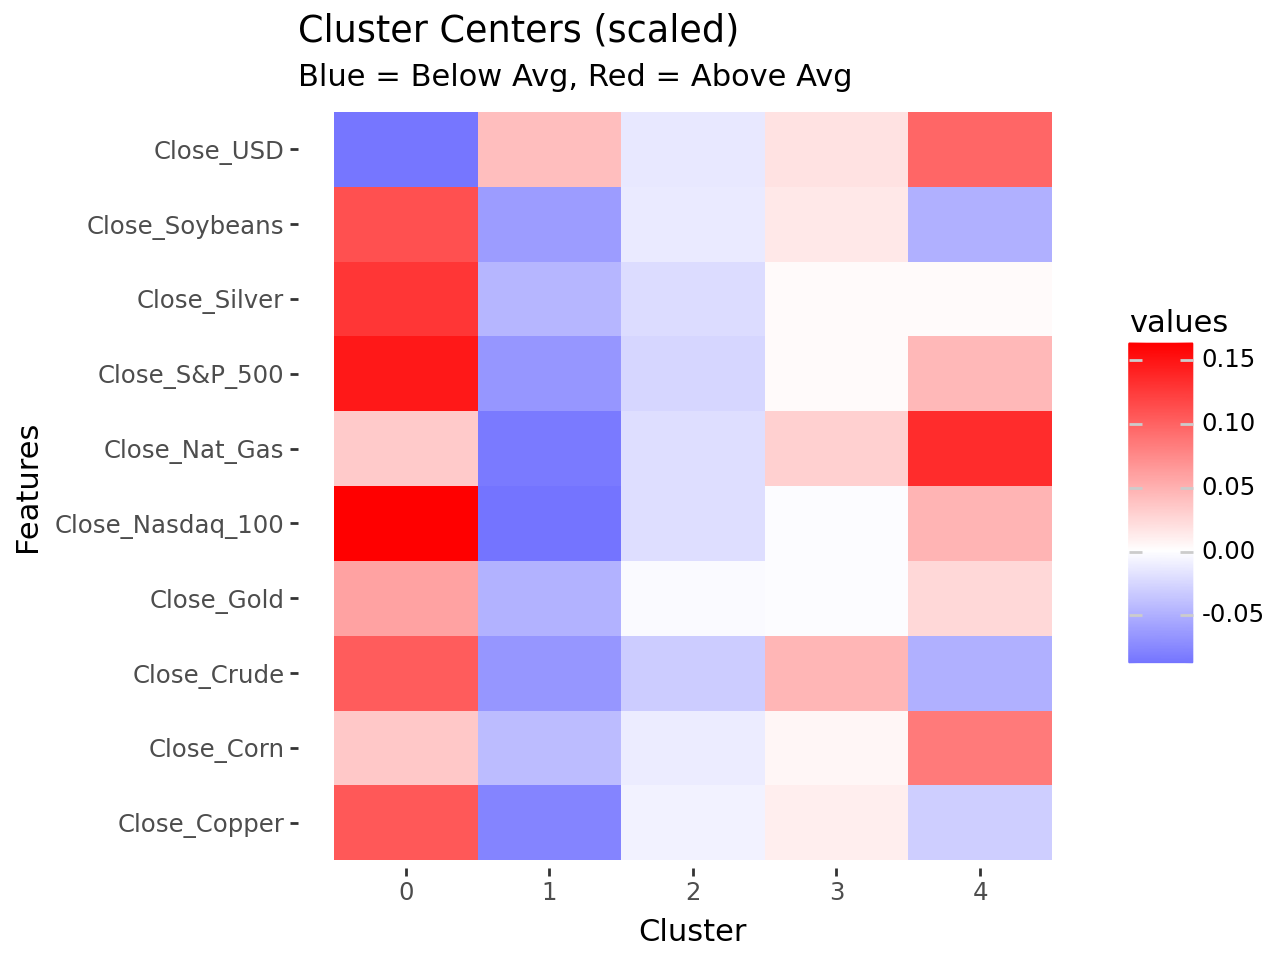

In [13]:
# Generate plot
g_heat_1 = (
    ggplot(data=center_long,                           # Set dataset
           mapping=aes(x="features", y="cluster", fill="values"))
    + scale_y_continuous(breaks=list(range(0, 5)))     # Set y axis breaks
    + geom_tile()                                        # Geom tile for heatmap
    + theme_bw()                             # Set theme
    + scale_fill_gradient2(                              # Diverging fill (centered at 0)
        low="blue", mid="white", high="red",
        midpoint=0, na_value="grey"         # Set midpoints
        # guide defaults to a colorbar in plotnine
    )
    + theme(                                             # Modify plot elements
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
    + labs(                                              # Add labels
        x="Features",
        y="Cluster",
        title="Cluster Centers (scaled)",
        subtitle="Blue = Below Avg, Red = Above Avg"
    )
    + coord_flip()                                       # Rotate plot to view names clearly
)

# Generate plot
g_heat_1

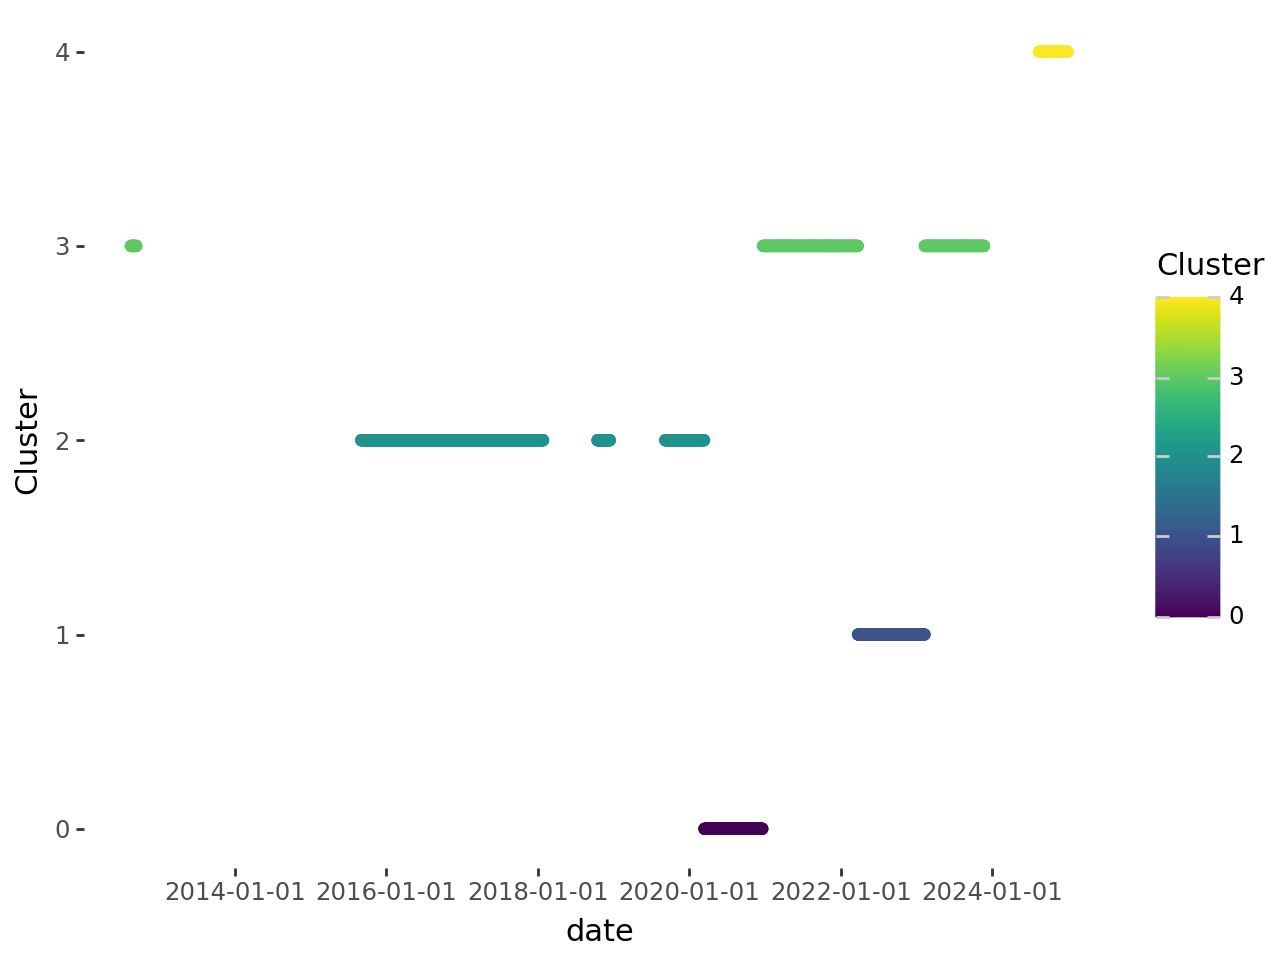

In [14]:
plot_data = data_clean.copy()
plot_data["date"] = plot_data.index

g_time_1 = (
    ggplot(data=plot_data,                           # Set dataset
           mapping=aes(x="date", y="Cluster", color = "Cluster"))

    + geom_point()                                        # Geom tile for heatmap
    + theme_bw()                             # Set theme
   
    + theme(                                             # Modify plot elements
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
                                         # Rotate plot to view names clearly
)
g_time_1

Calculate number of clusters

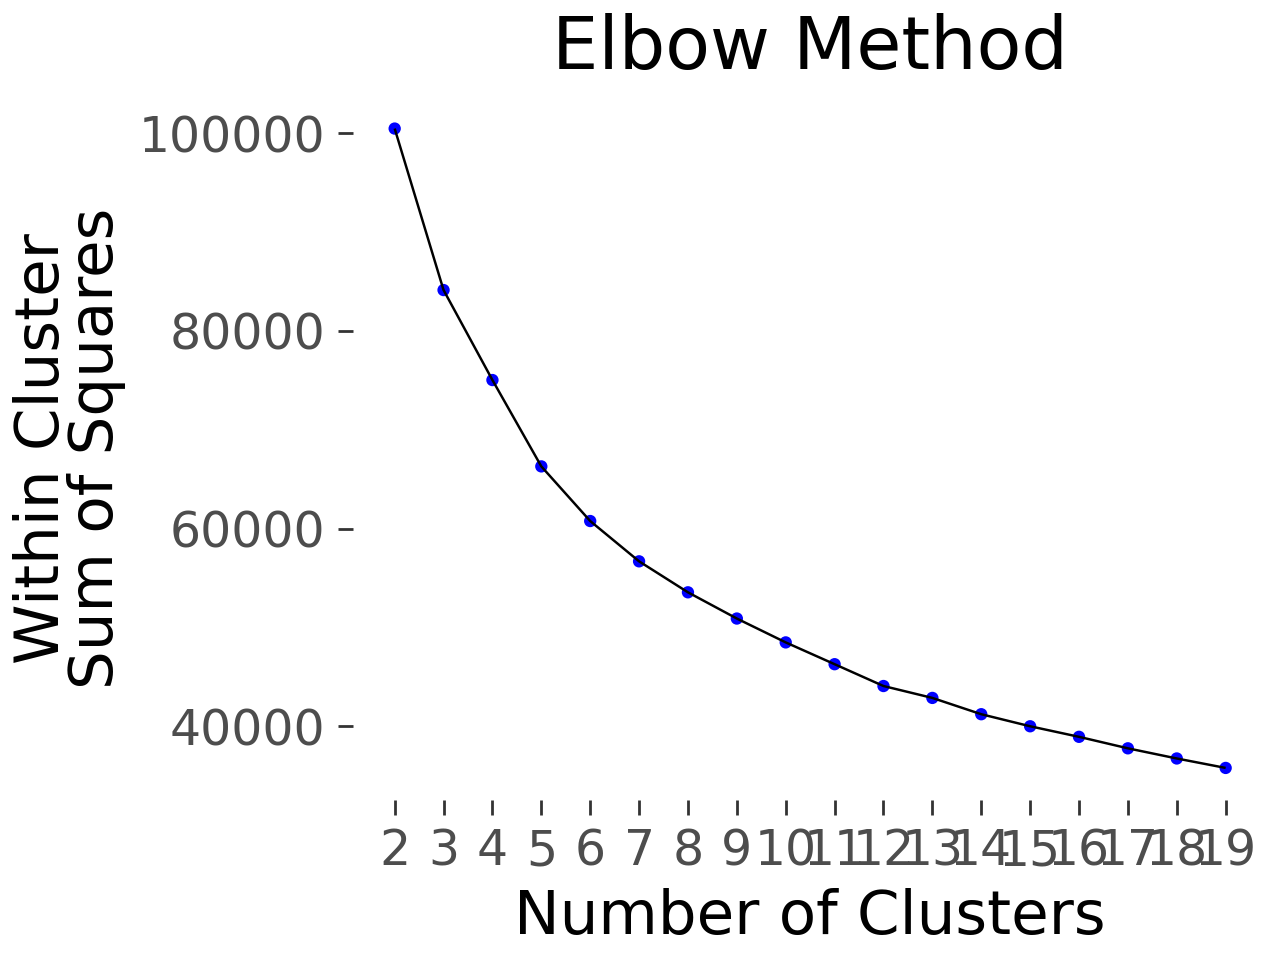

In [15]:
def kmeans_wss(k, X):
    km = KMeans(
        n_clusters=int(k),        # number of clusters
        n_init=25,                # number of random starts (R's nstart)
        max_iter=100,             # maximum iterations (R's iter.max)
        random_state=12345,       # reproducibility (R's set.seed)
        algorithm="lloyd"         # classic Lloyd's algorithm (closest to R)
    ).fit(X)
    return float(km.inertia_)     # total within-cluster sum of squares


# Compute WSS for a range of k values

ks = list(range(2, 20))    # Evaluate k = 2 to 20
wss = [kmeans_wss(k, scaled) for k in ks]

# Create a DataFrame for plotting
elbow = pd.DataFrame({"k": ks, "wss": wss})


# Plot the elbow curve
g_e1 = (
    ggplot(elbow, aes(x="k", y="wss"))          # Set dataset & aesthetics
    + theme_bw(base_size=22)                    # Set theme
    + geom_point(color="blue")                  # Points at each k
    + geom_line()                               # Line connecting points
    + scale_x_continuous(breaks=list(range(1, 20)))  # x-axis ticks 1 to 20
    + labs(
        x="Number of Clusters",
        y="Within Cluster\nSum of Squares",
        title="Elbow Method"
    )
    + theme(                                    # Clean up background
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
)

# Generate plot
g_e1

No real analysis can be found from this. Lets try with 6.

In [16]:
kmeans_6 = KMeans(
    n_clusters=6,
    n_init=25,
    max_iter=100,
    random_state=1234,
    algorithm="lloyd"
).fit(scaled)

# Add clusters to the dataset
data_clean["cluster_6"] = kmeans_6.labels_

# Count samples in each cluster
cluster_sizes = data_clean["cluster_6"].value_counts().sort_index()
print(cluster_sizes)

cluster_6
0    776
1    354
2    189
3    232
4     97
5    176
Name: count, dtype: int64


In [17]:
# Extract cluster centers
centers_df_6 = (
    pd.DataFrame(kmeans_6.cluster_centers_, columns=cols_to_scale)
    .assign(cluster=np.arange(0, 6))
    .loc[:, ["cluster"] + cols_to_scale.tolist()]
)
centers_df_6

,cluster,Close_USD,Close_Crude,Close_Nat_Gas,Close_Gold,Close_Silver,Close_Copper,Close_Corn,Close_Soybeans,Close_S&P_500,...,180-day STD_USD,180-day STD_Crude,180-day STD_Nat_Gas,180-day STD_Gold,180-day STD_Silver,180-day STD_Copper,180-day STD_Corn,180-day STD_Soybeans,180-day STD_S&P_500,180-day STD_Nasdaq_100
0,0,-0.014790,-0.032989,-0.021646,-0.003115,-0.021879,-0.008305,-0.011548,-0.013825,-0.026512,...,-0.646565,-0.243202,-0.997956,-0.510900,-0.633611,-0.606771,-0.989609,-0.638520,-0.773994,-0.639785
1,1,0.029602,0.029032,-0.027799,0.014385,-0.009816,-0.005173,-0.014730,0.000878,0.003746,...,-0.086228,0.173496,0.183628,-0.143796,-0.208482,1.158954,0.682004,0.008914,0.467730,0.139570
2,2,0.052225,-0.069930,-0.039479,-0.057594,-0.026864,-0.117174,-0.055667,-0.052265,-0.112932,...,1.555386,1.735827,0.958325,0.123211,1.095814,1.455857,1.245951,0.248557,1.398638,1.360003
3,3,-0.030829,0.081735,0.064444,-0.022941,0.015766,0.089396,0.048329,0.023596,0.041639,...,0.244701,-0.420823,0.906946,-0.080840,1.427804,-0.379399,0.494775,0.677442,1.385628,1.449043
4,4,0.097774,-0.050683,0.134302,0.025440,0.003765,-0.031267,0.084471,-0.050204,0.045992,...,-0.717744,-0.614057,1.243500,2.688922,0.624687,-0.349451,0.791877,1.077387,-0.545730,0.093487
5,5,-0.063663,0.082343,0.034779,0.062867,0.122201,0.072244,0.030060,0.111883,0.150395,...,1.426942,-0.247553,1.120768,1.034118,-0.190165,-0.526450,0.564902,1.043668,-0.555848,-0.881939


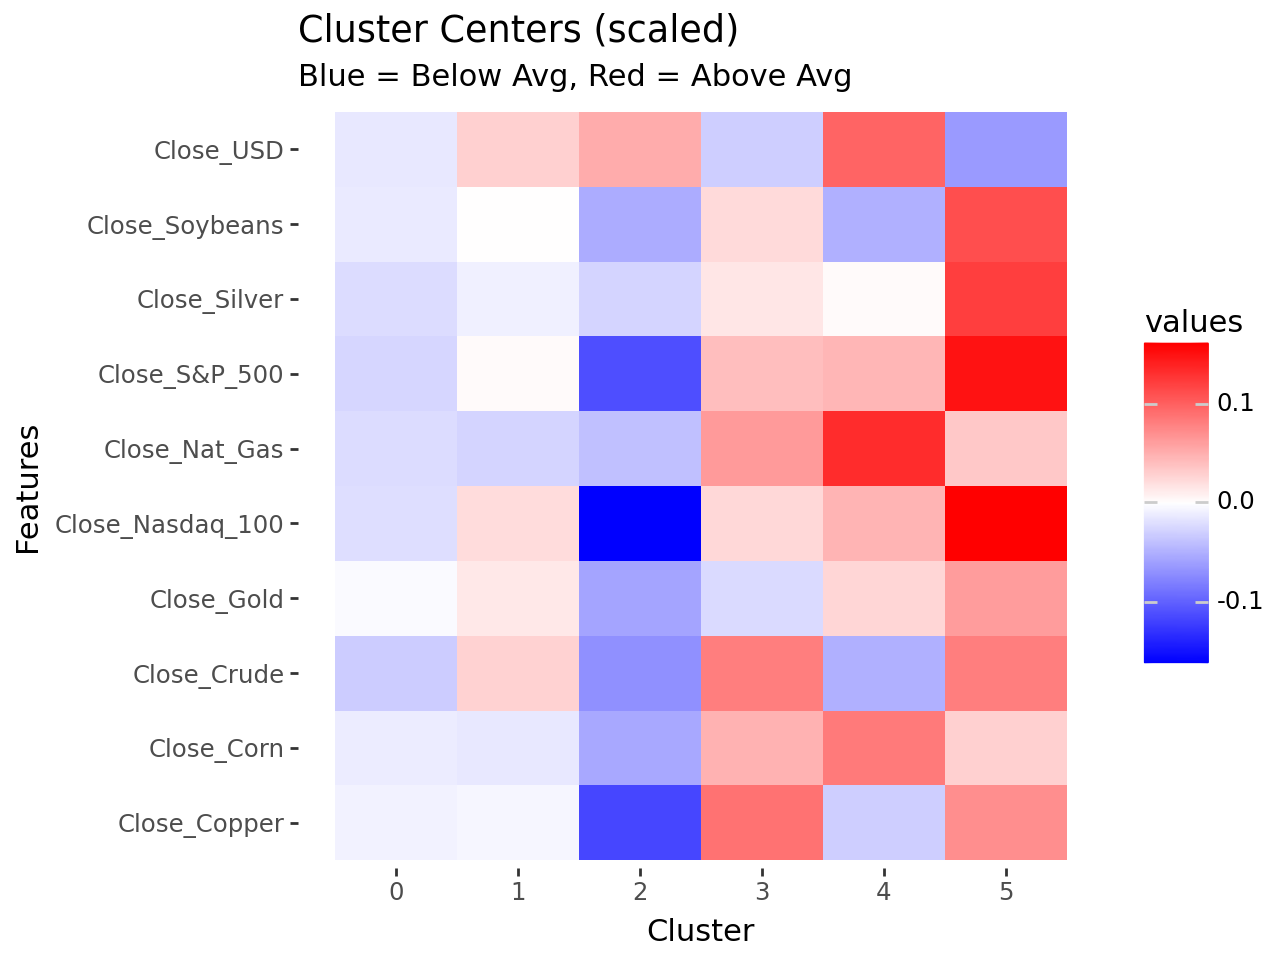

In [18]:
centers_df_6 = centers_df_6.iloc[:, :11]
# Convert data to long form
center_long_6 = (
    centers_df_6
    .melt(id_vars=["cluster"], var_name="features", value_name="values")
    .copy()
)
# Order variables alphabetically
sorted_features = sorted([c for c in centers_df_6.columns if c != "cluster"])
# Make 'features' an ordered categorical (so plot keeps our chosen order)
center_long_6["features"] = center_long_6["features"].astype(
    CategoricalDtype(categories=sorted_features, ordered=True)
)

# Generate plot
g_heat_2 = (
    ggplot(data=center_long_6,                           # Set dataset
           mapping=aes(x="features", y="cluster", fill="values"))
    + scale_y_continuous(breaks=list(range(0, 6)))     # Set y axis breaks
    + geom_tile()                                        # Geom tile for heatmap
    + theme_bw()                             # Set theme
    + scale_fill_gradient2(                              # Diverging fill (centered at 0)
        low="blue", mid="white", high="red",
        midpoint=0, na_value="grey"         # Set midpoints
        # guide defaults to a colorbar in plotnine
    )
    + theme(                                             # Modify plot elements
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
    + labs(                                              # Add labels
        x="Features",
        y="Cluster",
        title="Cluster Centers (scaled)",
        subtitle="Blue = Below Avg, Red = Above Avg"
    )
    + coord_flip()                                       # Rotate plot to view names clearly
)

# Generate plot
g_heat_2

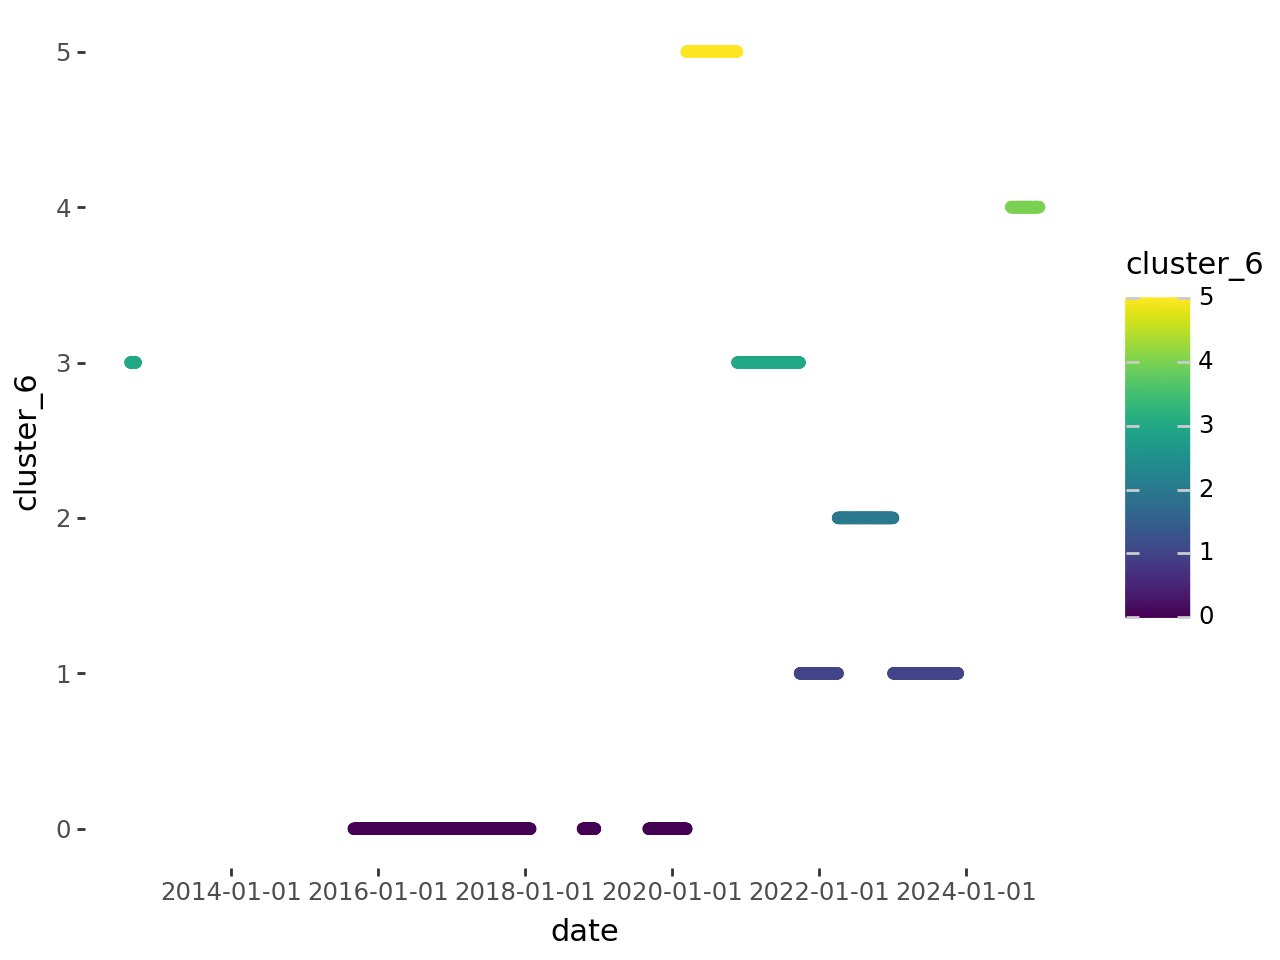

In [19]:
plot_data = data_clean.copy()
plot_data["date"] = plot_data.index

g_time_2 = (
    ggplot(data=plot_data,                           # Set dataset
           mapping=aes(x="date", y="cluster_6", color = "cluster_6"))

    + geom_point()                                        # Geom tile for heatmap
    + theme_bw()                             # Set theme
   
    + theme(                                             # Modify plot elements
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
                                         # Rotate plot to view names clearly
)
g_time_2

Silhouette Scores

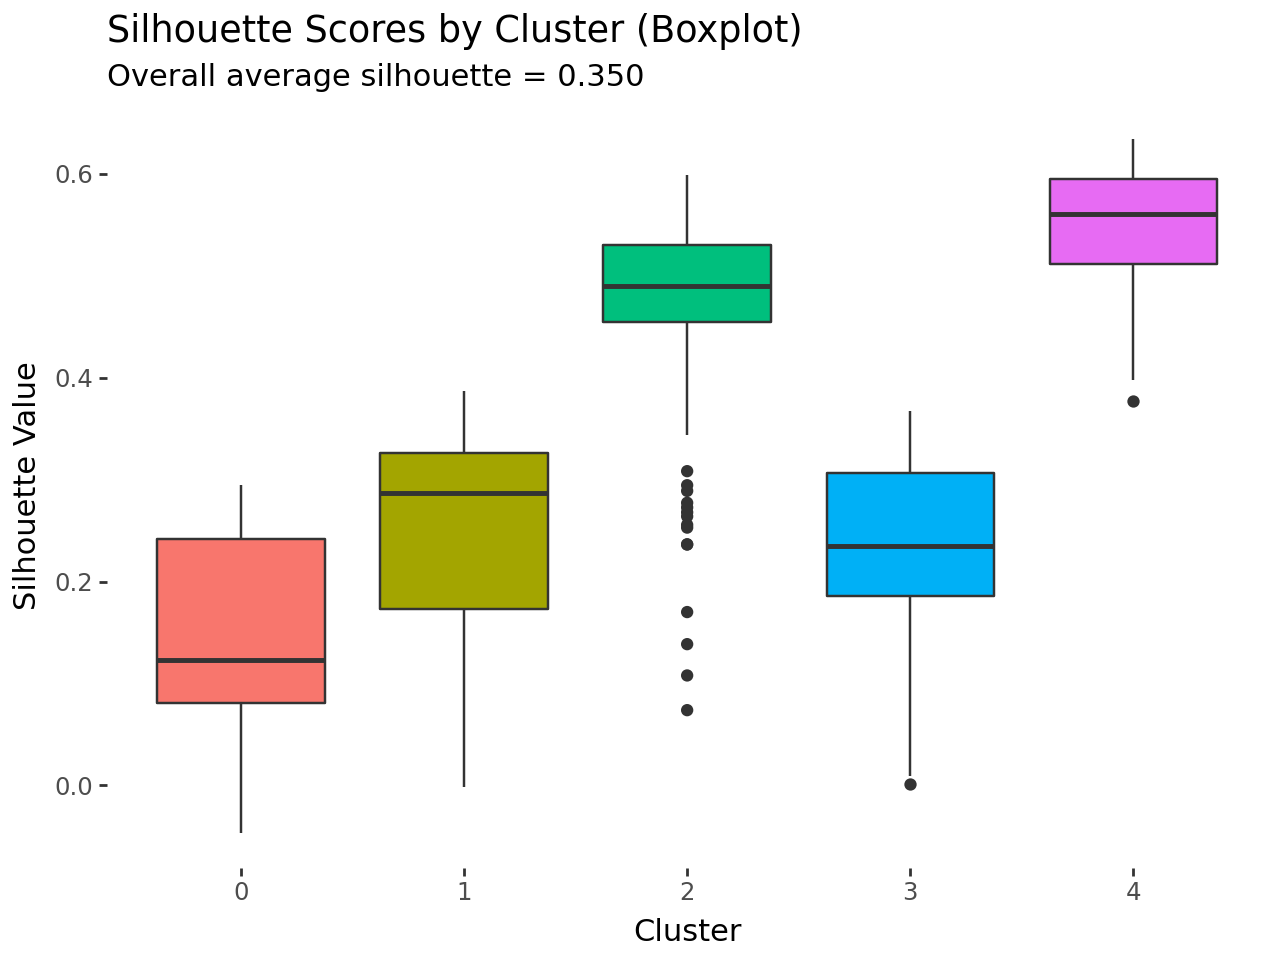

In [20]:
sil_samples_5 = silhouette_samples(scaled, kmeans_5.labels_, metric='euclidean')
sil_avg_5     = silhouette_score(scaled, kmeans_5.labels_, metric='euclidean')

# Convert to data frame:
sil_df_5 = (
    pd.DataFrame({
        "date": data_clean.index.astype(str),   # <-- FIXED LINE
        "cluster": kmeans_5.labels_.astype(int),
        "sil": sil_samples_5
    })
)

# Order data frame
sil_df_5 = (
    sil_df_5
    .sort_values(["cluster", "date"])
    .assign(order=lambda d: d.groupby("cluster").cumcount() + 1)
)

# Cluster averages
cluster_means_5 = (
    sil_df_5.groupby("cluster", as_index=False)["sil"].mean()
    .rename(columns={"sil": "avg_sil"})
)

g_sil_5 = (
    ggplot(sil_df_5, aes(x="factor(cluster)", y="sil", fill="factor(cluster)"))
    + geom_boxplot(show_legend=False)
    + theme_bw()
    + theme(
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
    + labs(
        title="Silhouette Scores by Cluster (Boxplot)",
        subtitle=f"Overall average silhouette = {sil_avg_5:.3f}",
        x="Cluster",
        y="Silhouette Value"
    )
)

g_sil_5

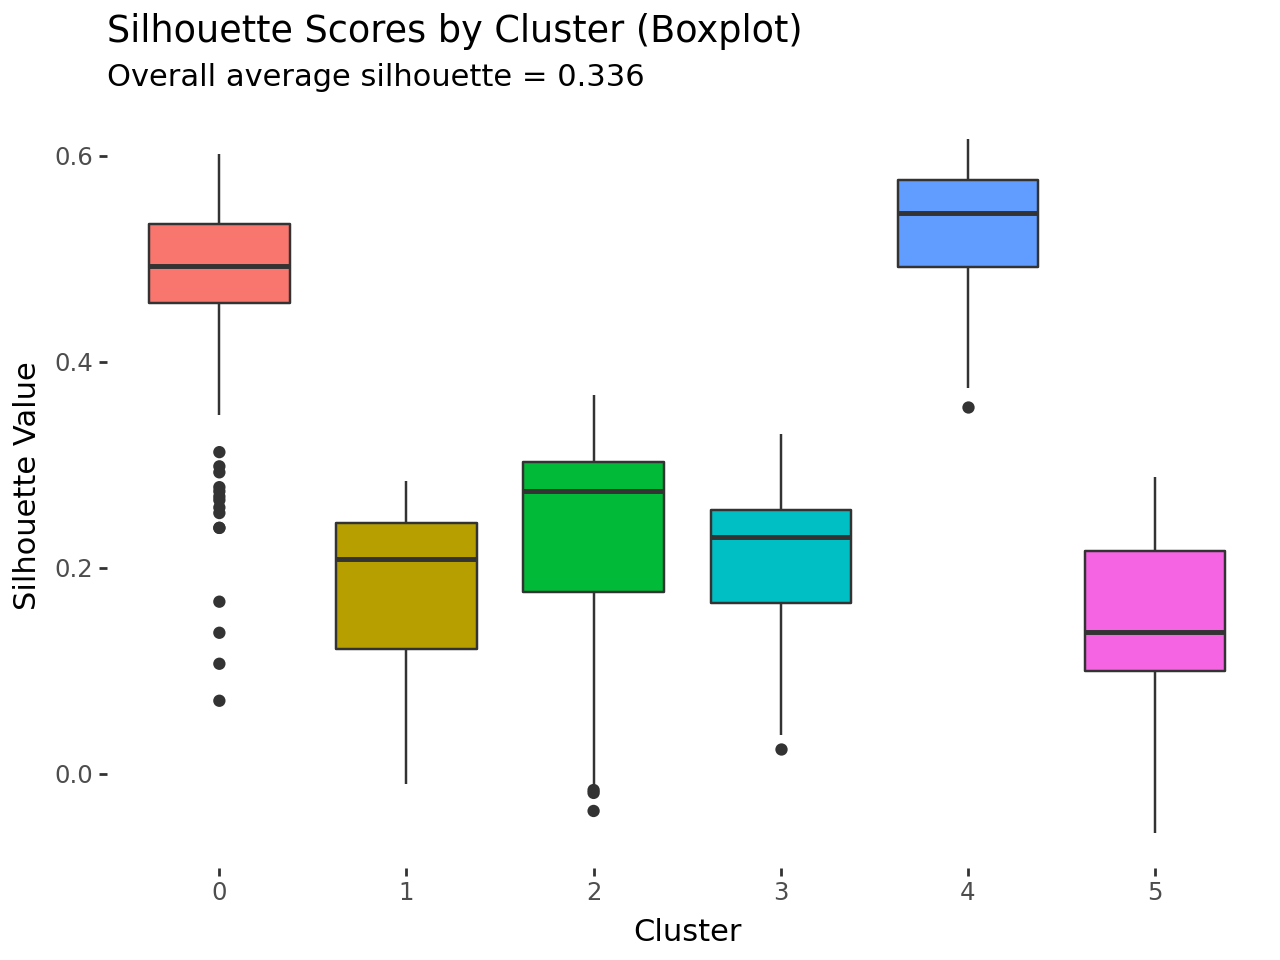

In [21]:
sil_samples_6 = silhouette_samples(scaled, kmeans_6.labels_, metric='euclidean')
sil_avg_6     = silhouette_score(scaled, kmeans_6.labels_, metric='euclidean')

# Convert to data frame:
sil_df_6 = (
    pd.DataFrame({
        "date": data_clean.index.astype(str),   # <-- FIXED LINE
        "cluster": kmeans_6.labels_.astype(int),
        "sil": sil_samples_6
    })
)

# Order data frame
sil_df_6 = (
    sil_df_6
    .sort_values(["cluster", "date"])
    .assign(order=lambda d: d.groupby("cluster").cumcount() + 1)
)

# Cluster averages
cluster_means_6 = (
    sil_df_6.groupby("cluster", as_index=False)["sil"].mean()
    .rename(columns={"sil": "avg_sil"})
)

g_sil_6 = (
    ggplot(sil_df_6, aes(x="factor(cluster)", y="sil", fill="factor(cluster)"))
    + geom_boxplot(show_legend=False)
    + theme_bw()
    + theme(
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
    + labs(
        title="Silhouette Scores by Cluster (Boxplot)",
        subtitle=f"Overall average silhouette = {sil_avg_6:.3f}",
        x="Cluster",
        y="Silhouette Value"
    )
)

g_sil_6

In [22]:
def silhouette_for_k(k, X):
    # Fit K-means with the same settings used elsewhere (nstart=25, iter.max=100)
    km = KMeans(
        n_clusters=int(k),
        n_init=25,
        max_iter=100,
        random_state=12345,
        algorithm="lloyd"
    ).fit(X)
    # Compute average silhouette (Euclidean)
    return float(silhouette_score(X, km.labels_, metric="euclidean"))

max_k = 20 # Set max clusters
ks = list(range(2, max_k + 1)) # Create list of values
sil_vals = [] # Create empty list to store results
for k in ks: # For each cluster number
        sil_vals.append(silhouette_for_k(k, scaled)) # Calculate and append silhouette score


sil_df = pd.DataFrame({"k": ks, "silhouette": sil_vals})
best_row = sil_df.loc[sil_df["silhouette"].idxmax()]
best_k = int(best_row["k"])
best_sil = float(best_row["silhouette"])

print(f"Best k by silhouette: k={best_k}, silhouette={best_sil:.3f}")

Best k by silhouette: k=2, silhouette=0.366


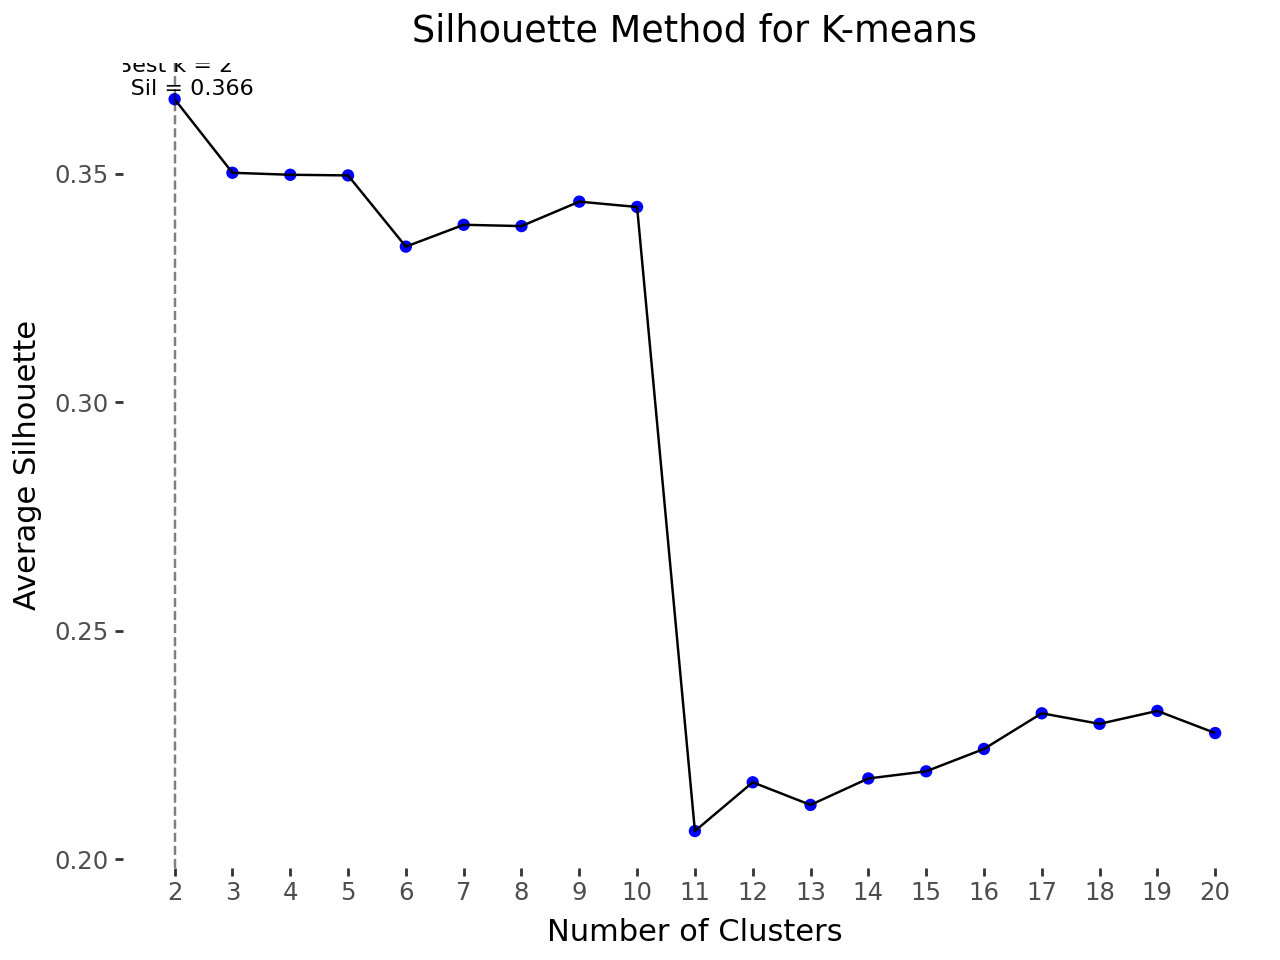

In [23]:
g_sil_nb = (
    ggplot(sil_df, aes(x="k", y="silhouette"))
    + theme_bw()                                    # Set theme
    + geom_point(color="blue")                                  # Scatter points
    + geom_line()                                               # Connect points
    + geom_vline(xintercept=best_k, linetype="dashed", alpha=0.5)
    + annotate("text", x=best_k, y=best_sil,
               label=f"Best k = {best_k}\n     Sil = {best_sil:.3f}",
               va="bottom", ha="center", size=8)
    + scale_x_continuous(breaks=list(range(2, max_k + 1)))      # x-axis ticks
    + labs(
        x="Number of Clusters",
        y="Average Silhouette",
        title="Silhouette Method for K-means"
    )
    + theme(                                                    # Remove grid
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
)

# Generate plot
g_sil_nb